In [93]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

409.46832614502375


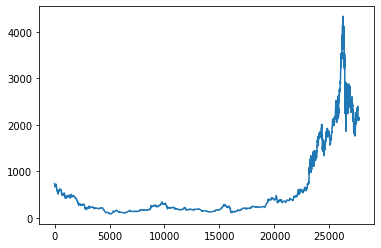

In [98]:
import polar_pla as pla
import numpy as np
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/eth.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp, 1000)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 12
train_proportion = 0.8

In [101]:
# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    input_numpy = []
    out_numpy = []
    for i in range(0, len(data)-seq_length, 2):
        #inputs.append(data[i:(i+seq_length)]) # the next n are the input
        #outputs.append(data[i+seq_length:i+seq_length+2]) # and the one after that is the output
        input_numpy.append(np.array(data[i:(i+seq_length)]).reshape(int(seq_length/2),2))
        out_numpy.append(np.array(data[i+seq_length:i+seq_length+2]))
        
    return Variable(torch.Tensor(input_numpy)), Variable(torch.Tensor(out_numpy))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)

trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

for i, (inputs, outputs) in enumerate(trainset):
   print(outputs.shape)



torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([5, 2])


In [115]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True
                            )
                            
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

num_epochs = 2000
learning_rate = 0.001

num_classes = 2
input_size = 2
hidden_size = 128
num_layers = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)




In [116]:


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, (trainX, trainY) in enumerate(trainset):
        optimizer.zero_grad()
        outputs = lstm(trainX)

        loss = criterion(outputs, trainY)
        loss.backward()
        
        optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))

Epoch: 0, loss: 0.41945568
Epoch: 100, loss: 0.00601490


KeyboardInterrupt: 

In [92]:
with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    for data in test:
        inputs, labels = data
        print(inputs.shape)
        output = lstm(inputs)
        lstm.zero_grad()
        total_loss += F.mse_loss(output, labels).item()
        #output = output[0]
        print(output.shape)
        print(labels.shape)
        if output[0][0] < 0 and labels[0][0] < 0 or output[0][0] > 0 and labels[0][0] > 0:
            correct += 1
            print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')

torch.Size([4, 2])


RuntimeError: input must have 3 dimensions, got 2